In [ ]:
!pip install tensorflow
!pip install datasets
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 14.8 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [ ]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.2 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow_datasets
!pip install pydot

In [ ]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt

import seaborn as sns
from tensorflow import keras
from sklearn.metrics import accuracy_score, confusion_matrix
from keras import optimizers
from keras import layers
from keras import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout, InputLayer
from os.path import isfile

print(tf.__version__)

2.15.0


In [ ]:
import numpy as np
import tensorflow_datasets as tfds

In [ ]:
# tf.config.list_physical_devices('GPU')

In [ ]:
def preprocess(image, label):
    image = tf.image.resize(image, [96, 96])
    # image = tf.image.rgb_to_grayscale(image)
    # image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
    return image, label


In [ ]:
def augment(image, label):
    image = tf.image.resize(image, [96, 96])
    # image = tf.image.rgb_to_grayscale(image)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1) # Adjust brightness by up to 10%
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1) # Adjust contrast between 90% and 110%
    # image = tf.cast(image, tf.float32) / 255.0
    return image, label


(ds_train, ds_validation, ds_test), ds_info = tfds.load(
    'malaria',
    split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
    as_supervised=True,
    with_info=True,
)

ds_train = ds_train.repeat(2)
ds_validation = ds_validation.repeat(2)

train_ds = ds_train.map(augment).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = ds_test.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = ds_validation.map(augment).batch(32).prefetch(tf.data.AUTOTUNE)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteWUFIQW/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [ ]:
img_width = 96
img_height = 96

img_size = (img_width, img_height)

In [ ]:
print(type(train_ds))

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("gelu")(x)

    previous_block_activation = x

    for size in [256, 512,]:
        x = layers.Activation("gelu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("gelu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("gelu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [ ]:
model = ...

pretrained_model_no = 1 # Change this number to the epoch of the model you want to load
pretrained_model_path = "./model_4_epoch_{0}.keras".format(pretrained_model_no)
is_model_trained = False

if isfile(pretrained_model_path):
    model = keras.models.load_model(pretrained_model_path) #load trained model
    is_model_trained = True

In [ ]:
if not is_model_trained:
    model = make_model(input_shape=img_size + (3,), num_classes=2)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 96, 96, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 48, 48, 128)          3584      ['rescaling[0][0]']           
                                                                                                  
 batch_normalization (Batch  (None, 48, 48, 128)          512       ['conv2d[0][0]']              
 Normalization)                                                                               

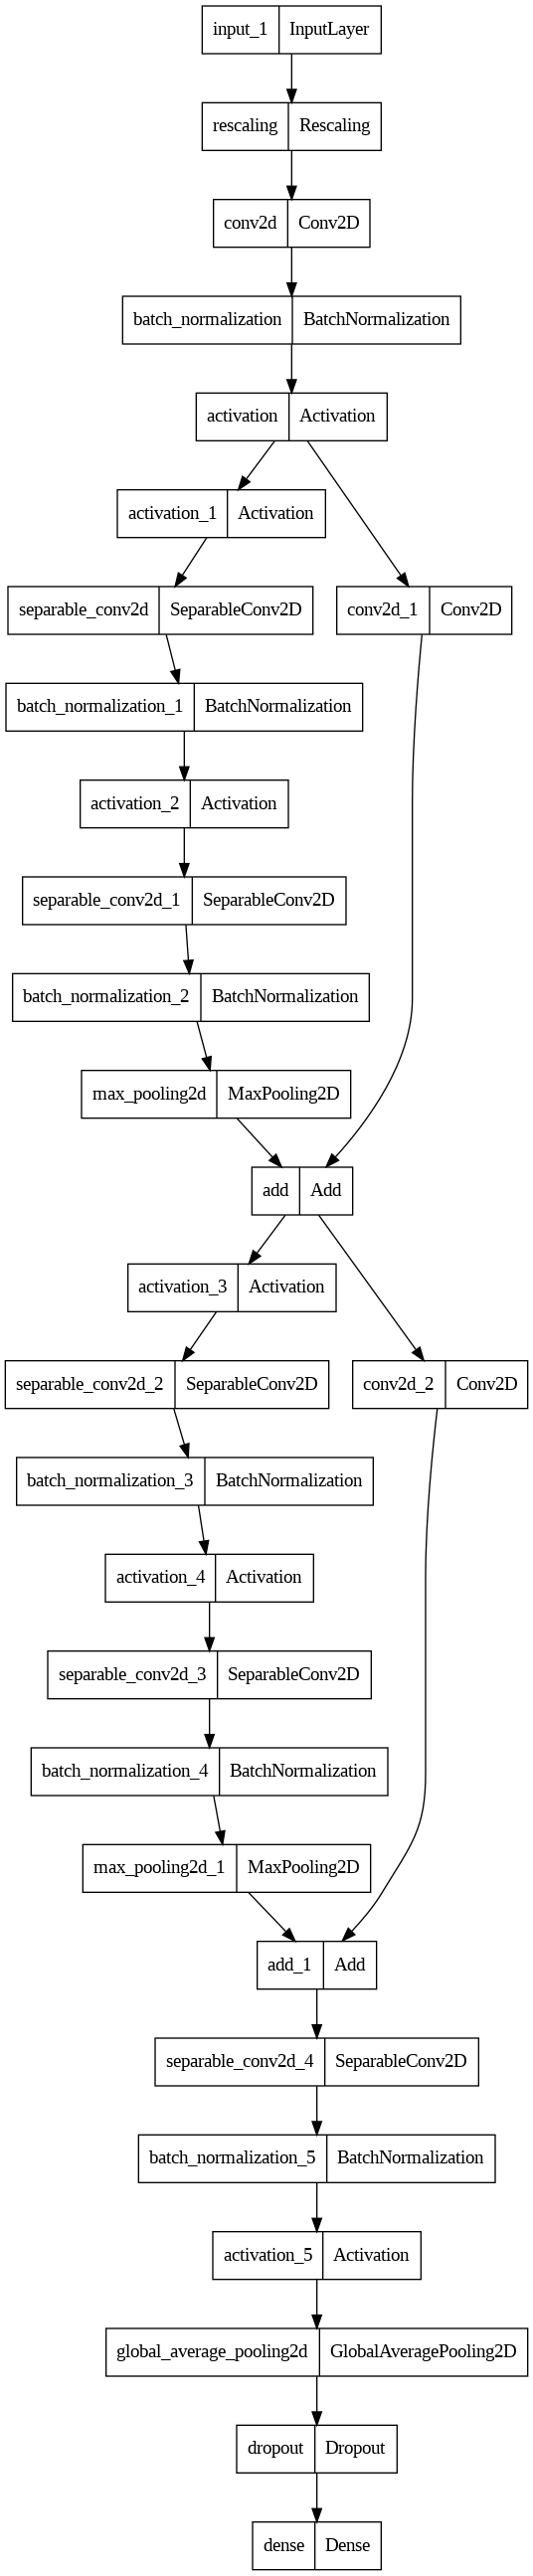

In [ ]:
keras.utils.plot_model(model)

In [ ]:
if not is_model_trained:
    epochs = 20

    callbacks = [
        keras.callbacks.ModelCheckpoint("model_4_epoch_{epoch}.keras"),
    ]
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    history = model.fit(
        train_ds,
        epochs=epochs,
        callbacks=callbacks,
        validation_data=val_ds,
    )

Epoch 1/20
1206/1206 [==============================] - 140s 106ms/step - loss: 0.1603 - accuracy: 0.9458 - val_loss: 0.1434 - val_accuracy: 0.9510
Epoch 2/20
1206/1206 [==============================] - 128s 106ms/step - loss: 0.1304 - accuracy: 0.9572 - val_loss: 0.2512 - val_accuracy: 0.9240
Epoch 3/20
1206/1206 [==============================] - 127s 105ms/step - loss: 0.1203 - accuracy: 0.9601 - val_loss: 0.1326 - val_accuracy: 0.9539
Epoch 4/20
1206/1206 [==============================] - 127s 105ms/step - loss: 0.1150 - accuracy: 0.9616 - val_loss: 0.4574 - val_accuracy: 0.8526
Epoch 5/20
1206/1206 [==============================] - 129s 107ms/step - loss: 0.1103 - accuracy: 0.9636 - val_loss: 0.2546 - val_accuracy: 0.9241
Epoch 6/20
1206/1206 [==============================] - 128s 106ms/step - loss: 0.1059 - accuracy: 0.9644 - val_loss: 0.1374 - val_accuracy: 0.9516
Epoch 7/20
1206/1206 [==============================] - 127s 105ms/step - loss: 0.1009 - accuracy: 0.9658 - val_

In [ ]:
is_model_trained = False

In [ ]:
best_model_no = ...

if not is_model_trained:
    test_loss, test_accuracy = model.evaluate(test_ds)
    print(f"Test Accuracy: {test_accuracy*100:.2f}%, Test Loss: {test_loss:.4f} \n")

    best_model_accuracy = ...

    for i in range(1,epochs+1):
        model_name_path = "./model_4_epoch_{0}.keras".format(i)
        current_model = keras.models.load_model(model_name_path)
        print("\n-------------------------Model {0}---------------------------------".format(i))
        test_loss, test_accuracy = current_model.evaluate(test_ds)
        print("Test Accuracy: {0:.2f}%, Test Loss: {1:.4f}".format(test_accuracy * 100, test_loss))
        if i == 1:
            best_model_no = i
            best_model_accuracy = test_accuracy
        else:
            if test_accuracy > best_model_accuracy:
                best_model_no = i
                best_model_accuracy = test_accuracy

    print("Best Model: Model {0}".format(best_model_no))
    pretrained_model_no = best_model_no
    is_model_trained = True
else:
    best_model_no = pretrained_model_no

130/130 [==============================] - 4s 31ms/step - loss: 0.1396 - accuracy: 0.9630
Test Accuracy: 96.30%, Test Loss: 0.1396 


-------------------------Model 1---------------------------------
130/130 [==============================] - 4s 31ms/step - loss: 0.1543 - accuracy: 0.9490
Test Accuracy: 94.90%, Test Loss: 0.1543

-------------------------Model 2---------------------------------
130/130 [==============================] - 5s 33ms/step - loss: 0.2688 - accuracy: 0.9180
Test Accuracy: 91.80%, Test Loss: 0.2688

-------------------------Model 3---------------------------------
130/130 [==============================] - 4s 31ms/step - loss: 0.1457 - accuracy: 0.9536
Test Accuracy: 95.36%, Test Loss: 0.1457

-------------------------Model 4---------------------------------
130/130 [==============================] - 5s 34ms/step - loss: 0.4798 - accuracy: 0.8476
Test Accuracy: 84.76%, Test Loss: 0.4798

-------------------------Model 5---------------------------------
130/130 

130/130 [==============================] - 4s 32ms/step


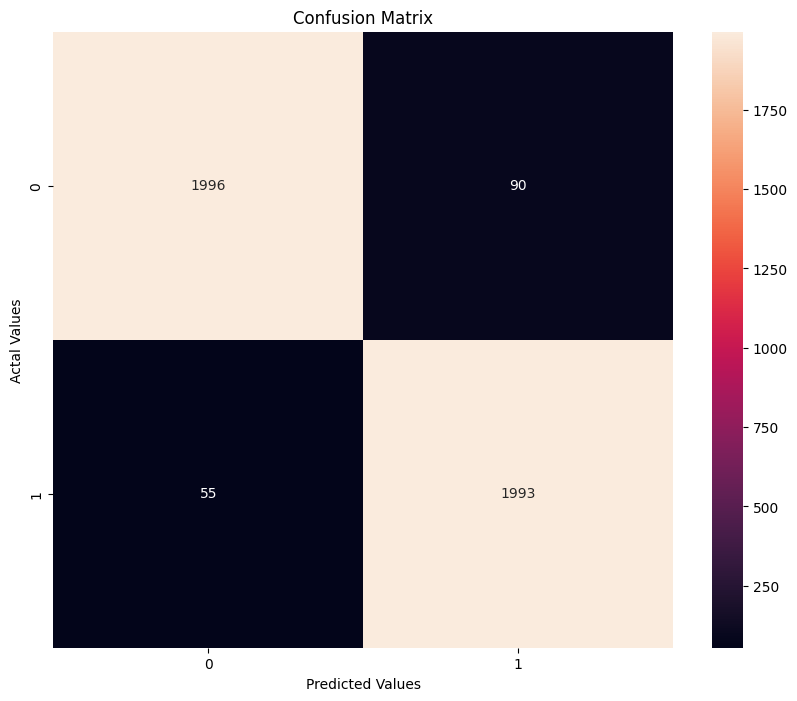

In [ ]:
best_model_path = "./model_4_epoch_{0}.keras".format(best_model_no)
best_model = keras.models.load_model(best_model_path)

def returnLabel(pred):
    if pred > 0.5:
        return 1
    return 0

y_pred = best_model.predict(test_ds)
retrieve = np.vectorize(returnLabel)
y_pred_binary = retrieve(y_pred)
y_test = np.concatenate([y for x, y in test_ds], axis=0)

cnf_mat = confusion_matrix(y_test, y_pred_binary)

#Code to print confusion matrix as a heatmap
plt.figure(figsize=(10,8))
sns.heatmap(cnf_mat, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
def plot_learningCurve(history, epoch):
  epoch_range= range(1, epoch+1)
  #plot training and validation accuracy values
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

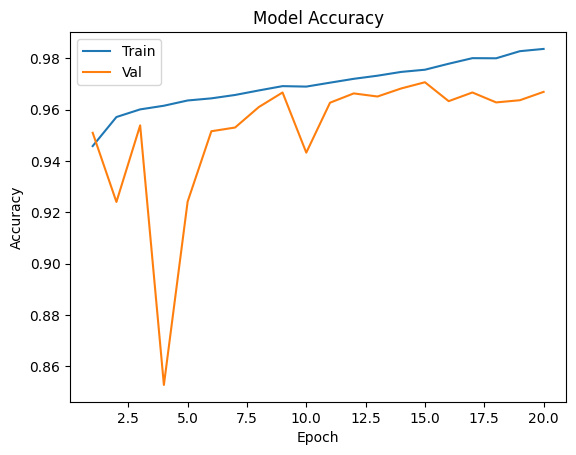

In [ ]:
plot_learningCurve(history, 20)